In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

C:\Users\mptib\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\mptib\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [113]:
data = pd.read_csv('train.csv')
y = data['SalePrice']
X = data.drop(['Id', 'SalePrice'], axis=1)

In [116]:
test_size = .3
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)

Text(0.5, 1.0, 'Distribution of Housing Prices')

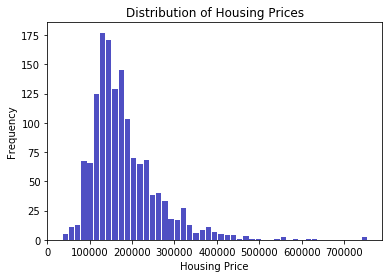

In [9]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Housing Price')
plt.ylabel('Frequency')
plt.title('Distribution of Housing Prices')

In [117]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = list(X.select_dtypes(exclude=['object']).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = list(X.select_dtypes(include=['object']).columns)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X = preprocessor.fit_transform(X)

In [125]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_model =  XGBRegressor()
param_grid = {
    "n_estimators": [1000, 5000, 10000],
    "learning_rate": [0.1, 0.05, .01, .001],
}

searchCV = GridSearchCV(estimator=xgb_model,
                        cv=5,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_log_error')
searchCV.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)],
             early_stopping_rounds=10,
             verbose=False)  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_we..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1000, 5000, 10000], 'learning_rate': [0.1, 0.05, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=0)

In [121]:
searchCV.best_params_

{'learning_rate': 0.01, 'n_estimators': 5000}

In [124]:
[math.sqrt(i) for i in searchCV.cv_results_['mean_test_score']]

array([-8.53522914e+08, -8.53522914e+08, -8.53522914e+08, -8.38917031e+08,
       -8.38917031e+08, -8.38917031e+08, -8.23120905e+08, -8.21640810e+08,
       -8.21640810e+08, -6.81917492e+09, -8.46932846e+08, -8.29937866e+08])

In [101]:
model_1 = XGBRegressor(**searchCV.best_params_)
model_1.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [107]:
test = pd.read_csv('test.csv')
X_test = preprocessor.transform(test)

In [110]:
prediction = model_1.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction})

submission.to_csv('Predictions/HousingPrices1.csv', index=False)